# Projecting data onto HypoMap
This notebook shows how to embed you query data into HypoMap using the pre-computed scvi models and transfer labels of Hypomap cluster levels onto the query data similar to the scArches algorithm.

See also the original scArches implementation: https://github.com/theislab/scarches/blob/master/scarches/utils/knn.py#L44

Authors: Marvin Feldmann, Lukas Steuernagel, Elliot H. von Rein

## Import libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import scipy.sparse as sp
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import time
import os


scvi.settings.seed = 12345
print(f" When running this script for older scvi models it requires pandas 1.5.3, you have {pd.__version__}. #!pip install 'pandas<2.0.0' might do the trick")

Seed set to 12345


 When running this script for older scvi models it requires pandas 1.5.3, you have 1.5.3. #!pip install 'pandas<2.0.0' might do the trick


### Specify input and output paths

HypoMap Datasets are available from:
- Human:
- Mouse: https://keeper.mpdl.mpg.de/d/1d250b01f5604aad99fc/
(official R object for mouse here: https://doi.org/10.17863/CAM.87955 )

HypoMap Models are available from here:
- Human: https://github.com/lsteuernagel/HYPOMAP/tree/main/human_hypo_scVI_model
- Mouse: https://github.com/lsteuernagel/mapscvi/tree/master/inst/extdata/models/hypoMap_harmonized_scVI_model

Newer models that are compatible with pandas > 2.0.0 are available here:
- Human: https://github.com/lsteuernagel/HYPOMAP/tree/main/human_hypo_scVI12_model
- Mouse:

In this example we are mapping the human Visium 10x data from human HypoMap onto the nucseq data (which does not work out very well).

In [ ]:
hypomap_path = "/beegfs/scratch/bruening_scratch/lsteuernagel/data/human_HYPOMAP_publication/human_HYPOMAP.h5ad"
model_path = "/beegfs/scratch/bruening_scratch/lsteuernagel/projects/human_hypomap_publication_2/human_hypo_scVI_model/"
query_path = "/beegfs/scratch/bruening_scratch/lsteuernagel/data/human_HYPOMAP_publication/spatial/humanHYPOMAP_spatial_collage.h5ad"

In [5]:
transferred_save_path = "/beegfs/scratch/bruening_scratch/lsteuernagel/data/dump/output_transferred.h5ad"

## Load reference data
Modify the path to you local version of the human or mouse HypoMap object (or any other ference data set which you have an scvi model for).
Also specify the path to your query data

In [6]:
ref_adata = anndata.read_h5ad(hypomap_path)

In [75]:
query_adata = anndata.read_h5ad(query_path)

## Prepare query data
We run the prepare query data and add Batch_ID (mouse) or Sample_ID (human) columns.
If you consider the whole data set as a single/sample batch set just to one value. Or overwrite with you most fitting batch or sample level in .obs

Only run those steps that are necessary.

In [82]:
# scvi expects un-normalized counts: move the raw counts to .X
query_adata.X = query_adata.raw.X
#ensure sparse matrix
query_adata.X = sp.csr_matrix(query_adata.X)
# prep
query_adata = scvi.model.SCVI.prepare_query_anndata(query_adata, model_path, inplace = False)
query_adata.obs['Batch_ID'] = f"query_batch_1"
# query_adata.obs['Batch_ID'] = f"query_batch_1"
# query_adata.obs['Batch_ID'] = query_adata.obs['sample'] # example
query_adata.obs['Sample_ID'] = query_adata.obs['slideNumber'] # example

INFO     File                                                                                                      
         /beegfs/scratch/bruening_scratch/lsteuernagel/projects/human_hypomap_publication_2/human_hypo_scVI_model/m
         odel.pt already downloaded                                                                                
INFO     Found 67.47999999999999% reference vars in query data.                                                    


/tmp/ipykernel_2378998/1367631462.py:6: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  query_adata = scvi.model.SCVI.prepare_query_anndata(query_adata, model_path, inplace = False)
/usr/local/lib/python3.10/dist-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


## Prepare function
Load function to run label transfer on data

In [136]:
# train knn classifier
def weighted_knn_transfer_all_labels(
    query_adata,
    ref_adata,
    label_keys,
    embedding_name = "X_scvi",
    n_neighbors=30,
    n_trees_annoy = 50
):
    """Modified function from scArches 
    https://github.com/theislab/scarches/blob/master/scarches/utils/knn.py#L44
    
    Annotates ``query_adata`` cells with an input trained weighted KNN classifier.
    
    Parameters
    ----------
    query_adata: :class:`~anndata.AnnData`
        Annotated dataset to be used to query KNN classifier. 
    ref_adata: :class:`~anndata.AnnData`
        ref Anndata
    label_keys: str
        Names of the columns to be used as target variables (e.g. cell_type) in ``query_adata``
    embedding_name: str
        Name of the obsm layer to be used for label transfer. If set to "X",query_adata.X will be used
    """
    
    import pandas as pd
    import scipy.sparse as sp
    from annoy import AnnoyIndex

    if embedding_name == "X":
        query_emb = query_adata.X
    elif embedding_name in query_adata.obsm.keys():
        query_emb = query_adata.obsm[embedding_name]
    else:
        raise ValueError(
            "embedding_name should be set to either 'X' or the name of the obsm layer to be used!"
        )

    # check
    if not(all(col in ref_adata.obs.columns for col in label_keys)):
        raise ValueError(
            "One or more key in label_keys are not column names of ref_adata.obs"
        )

    # Define the Annoy index with the dimensionality of the embeddings and Euclidean distance
    embedding_dim = ref_adata.obsm[embedding_name].shape[1]
    query_nn = AnnoyIndex(embedding_dim, metric='euclidean')
    
    # Build the Annoy index on the reference data
    for i, embedding in enumerate(ref_adata.obsm[embedding_name]):
        query_nn.add_item(i, embedding)
        
    query_nn.build(n_trees_annoy)  # Number of trees, adjust based on dataset size and desired accuracy
    
    # Find the k-nearest neighbors for each query point
    print('annoy')
    top_k_indices = []
    top_k_distances = []
    for query_embedding in query_adata.obsm[embedding_name]:
        indices, distances = query_nn.get_nns_by_vector(query_embedding, n_neighbors, include_distances=True)
        top_k_indices.append(indices)
        top_k_distances.append(distances)
    
    # Convert results to numpy arrays 
    knn_indices = np.array(top_k_indices)
    knn_dists = np.array(top_k_distances)
    
    # Compute the standard deviation for each query point's neighbors
    knn_sd = np.sqrt((knn_dists**2).sum(axis=1) / n_neighbors)
    
    # Apply the Gaussian kernel to the neighbor distances
    knn_gauss = np.exp(-knn_dists / (2 / knn_sd[:, np.newaxis])**2)
    
    # Create a sparse matrix from the Gaussian-weighted distances and indices
    indptr = np.arange(0, (n_neighbors * query_adata.shape[0]) + 1, n_neighbors)
    gauss_matrix = sp.csr_matrix((knn_gauss.ravel(), knn_indices.ravel(), indptr), shape=(query_adata.shape[0], ref_adata.shape[0]))
    
    # Normalize the matrix such that the neighbors sum to 1 across each row
    # gauss_mtx = (gauss_matrix / gauss_matrix.sum(axis=1)).tocsr()
    sums_v = sp.csr_matrix(1/gauss_matrix.sum(axis=1)) # avoid dense
    gauss_mtx = gauss_matrix.multiply(sums_v)

    # Initialize a list to store results for each label
    query_labels_dict = {}
    query_label_probs_dict = {}
    print('labels')
    # loop over all labels
    for label in label_keys:
        # Initialize a sparse matrix to store label probabilities
        unique_labels = ref_adata.obs[label].unique()
        label_probs = sp.lil_matrix((query_adata.shape[0], len(unique_labels)))
    
        # Calculate label probabilities by summing Gaussian weights for each label
        for idx, u_label in enumerate(unique_labels):
            cluster_mask = ref_adata.obs[label] == u_label
            label_probs[:, idx] = gauss_mtx[:, cluster_mask].sum(axis=1).A1
    
        # Convert label probabilities to CSR format
        query_label_probs = label_probs.tocsr()
        query_label_probs_dict[f'{label}_probs'] = query_label_probs
        query_label_probs_dict[f'{label}_labels'] = unique_labels
        
        # Find the label with the maximum probability for each query point
        top_label_idx = query_label_probs.argmax(axis=1).A1
        label_confidence = query_label_probs.max(axis=1).A.ravel()
        query_label = unique_labels[top_label_idx]
        
        # Convert labels and confidence scores to pandas Series
        query_label = pd.Series(query_label, index=query_adata.obs.index, dtype="category")
        label_confidence = pd.Series(label_confidence, index=query_adata.obs.index, dtype='float32')
        # Store each label's results in a dictionary
        query_labels_dict[f'{label}_label'] = pd.Series(query_label, index=query_adata.obs.index, dtype="category")
        query_labels_dict[f'{label}_confidence'] = pd.Series(label_confidence, index=query_adata.obs.index, dtype='float32')

    # Combine all label and confidence results into a single DataFrame
    query_label_df = pd.DataFrame(query_labels_dict, index=query_adata.obs.index)

    return query_label_df, query_label_probs_dict

## Run projection onto hypomap model
Apply above functions and scvitools to embed the query data using the existing model

Usually training for 10-20 epochs is sufficient.

In [84]:
# create the new query model instance.
vae_query = scvi.model.SCVI.load_query_data(
    query_adata,
    model_path
)

# train
vae_query.train(max_epochs=20, plan_kwargs=dict(weight_decay=0.0))

# get latent embeddings
query_adata.obsm["X_scvi"] = vae_query.get_latent_representation()

INFO     File                                                                                                      
         /beegfs/scratch/bruening_scratch/lsteuernagel/projects/human_hypomap_publication_2/human_hypo_scVI_model/m
         odel.pt already downloaded                                                                                


/usr/local/lib/python3.10/dist-packages/scvi/model/_scvi.py:155: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:37<00:00, 13.84s/it, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.34e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:37<00:00, 13.86s/it, v_num=1, train_loss_step=1.27e+3, train_loss_epoch=1.34e+3]


## Run label transfer

Uses the knn classifier to transfer labels from reference (HypoMap) onto query.

Returns a pandas dataframe with the highest label and the confidence, which is usually the most relevant result to annotate new cells. This can then be added to adata.obs . Als returns a dict with all probabilities for all labels for each cell.

In [85]:
# pick keys you are interested in
LABEL_KEYS = ["C1_named", "C2_named", "C3_named", "C4_named"]
# LABEL_KEYS = ["C66_named", "C185_named", "C286_named"]

In [86]:
query_label_df, query_label_probs_dict = weighted_knn_transfer_all_labels(
    query_adata = query_adata,
    embedding_name = "X_scvi",
    ref_adata = ref_adata,
    label_keys = LABEL_KEYS,
    n_neighbors=30,
    n_trees_annoy = 50
)

annoy


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_base.py:713: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_base.py:713: RuntimeWarning: overflow encountered in divide
  recip = np.true_divide(1., other)
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_compressed.py:475: RuntimeWarning: invalid value encountered in multiply
  data = np.multiply(ret.data, other[ret.row].ravel())


labels


In [96]:
# df with labels
query_label_df

,C1_named_label,C1_named_confidence,C2_named_label,C2_named_confidence,C3_named_label,C3_named_confidence,C4_named_label,C4_named_confidence
AACAATCCGAGTGGAC-1_1,C1-1 Astrocytes,0.557607,C2-3 Astrocytes-3,0.551767,C3-10 Astrocytes-3 NRXN3,0.551767,C3-10 Astrocytes-3 NRXN3,0.551767
AACAATGGAACCACAT-1_1,C1-10 Mid-2,0.898030,C2-43 Mid-2 GLU-3,0.898030,C3-128 Mid-2 GLU-3 PMCH,0.898030,C4-372 Mid-2 GLU-3 PMCH,0.898030
AACAATGTGCTCCGAG-1_1,C1-12 Vascular,0.970321,C2-48 Vascular,0.970321,C3-141 Vascular Endothelial,0.970321,C3-141 Vascular Endothelial,0.970321
AACACCAGCCTACTCG-1_1,C1-10 Mid-2,0.986633,C2-43 Mid-2 GLU-3,0.986633,C3-128 Mid-2 GLU-3 PMCH,0.986633,C4-372 Mid-2 GLU-3 PMCH,0.986633
AACACCATACGATAGT-1_1,C1-10 Mid-2,0.996131,C2-43 Mid-2 GLU-3,0.996131,C3-128 Mid-2 GLU-3 PMCH,0.996131,C4-372 Mid-2 GLU-3 PMCH,0.996131
...,...,...,...,...,...,...,...,...
TGTTGGTGAGCGGACG-1_9,C1-12 Vascular,0.999894,C2-48 Vascular,0.999894,C3-141 Vascular Endothelial,0.999894,C3-141 Vascular Endothelial,0.999894
TGTTGGTGCGCACGAG-1_9,C1-12 Vascular,0.920402,C2-48 Vascular,0.920402,C3-141 Vascular Endothelial,0.885649,C3-141 Vascular Endothelial,0.885649
TGTTGGTGCGCTTCGC-1_9,C1-12 Vascular,0.938248,C2-48 Vascular,0.938248,C3-141 Vascular Endothelial,0.937353,C3-141 Vascular Endothelial,0.937353
TGTTGGTGCGGAATCA-1_9,C1-10 Mid-2,0.999873,C2-43 Mid-2 GLU-3,0.999873,C3-128 Mid-2 GLU-3 PMCH,0.999873,C4-372 Mid-2 GLU-3 PMCH,0.999873


In [116]:
# all probabilities
query_label_probs_dict

{'C1_named': <86041x13 sparse matrix of type '<class 'numpy.float64'>'
 	with 320383 stored elements in Compressed Sparse Row format>,
 'C2_named': <86041x52 sparse matrix of type '<class 'numpy.float64'>'
 	with 358783 stored elements in Compressed Sparse Row format>,
 'C3_named': <86041x156 sparse matrix of type '<class 'numpy.float64'>'
 	with 458422 stored elements in Compressed Sparse Row format>,
 'C4_named': <86041x452 sparse matrix of type '<class 'numpy.float64'>'
 	with 458558 stored elements in Compressed Sparse Row format>}

In [125]:
# subsetting this query object a bit further - not necessary in general
query_adata.obs = query_adata.obs.iloc[:,0:12]

In [126]:
# Ensure query_label_df has the same index as query_adata.obs
query_label_df = query_label_df.reindex(query_adata.obs.index)
# add to adata
query_adata.obs = pd.concat([query_adata.obs, query_label_df], axis=1)

In [127]:
query_adata.obs.columns

Index(['cell_id', 'nCount_RNA', 'nFeature_RNA', 'captureArea', 'Experiment',
       'slideNumber', 'donorID', 'Sex', 'Age', 'BMI',
       'regional_clusters_named', 'regional_clusters_grouped',
       'C1_named_label', 'C1_named_confidence', 'C2_named_label',
       'C2_named_confidence', 'C3_named_label', 'C3_named_confidence',
       'C4_named_label', 'C4_named_confidence'],
      dtype='object')

In [ ]:
# save results
adata_query.write_h5ad(transferred_save_path)

## Make a new umap and color by transferred labels

As an example we calculate a new umap of the query data using the existing embedding and plot the C1 labels on it.

This worked very terribly with the Visium data (maybe unsurprisingly)

In [134]:
sc.pp.neighbors(query_adata,use_rep = 'X_scvi',n_pcs = query_adata.obsm['X_scvi'].shape[1])
sc.tl.umap(query_adata)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


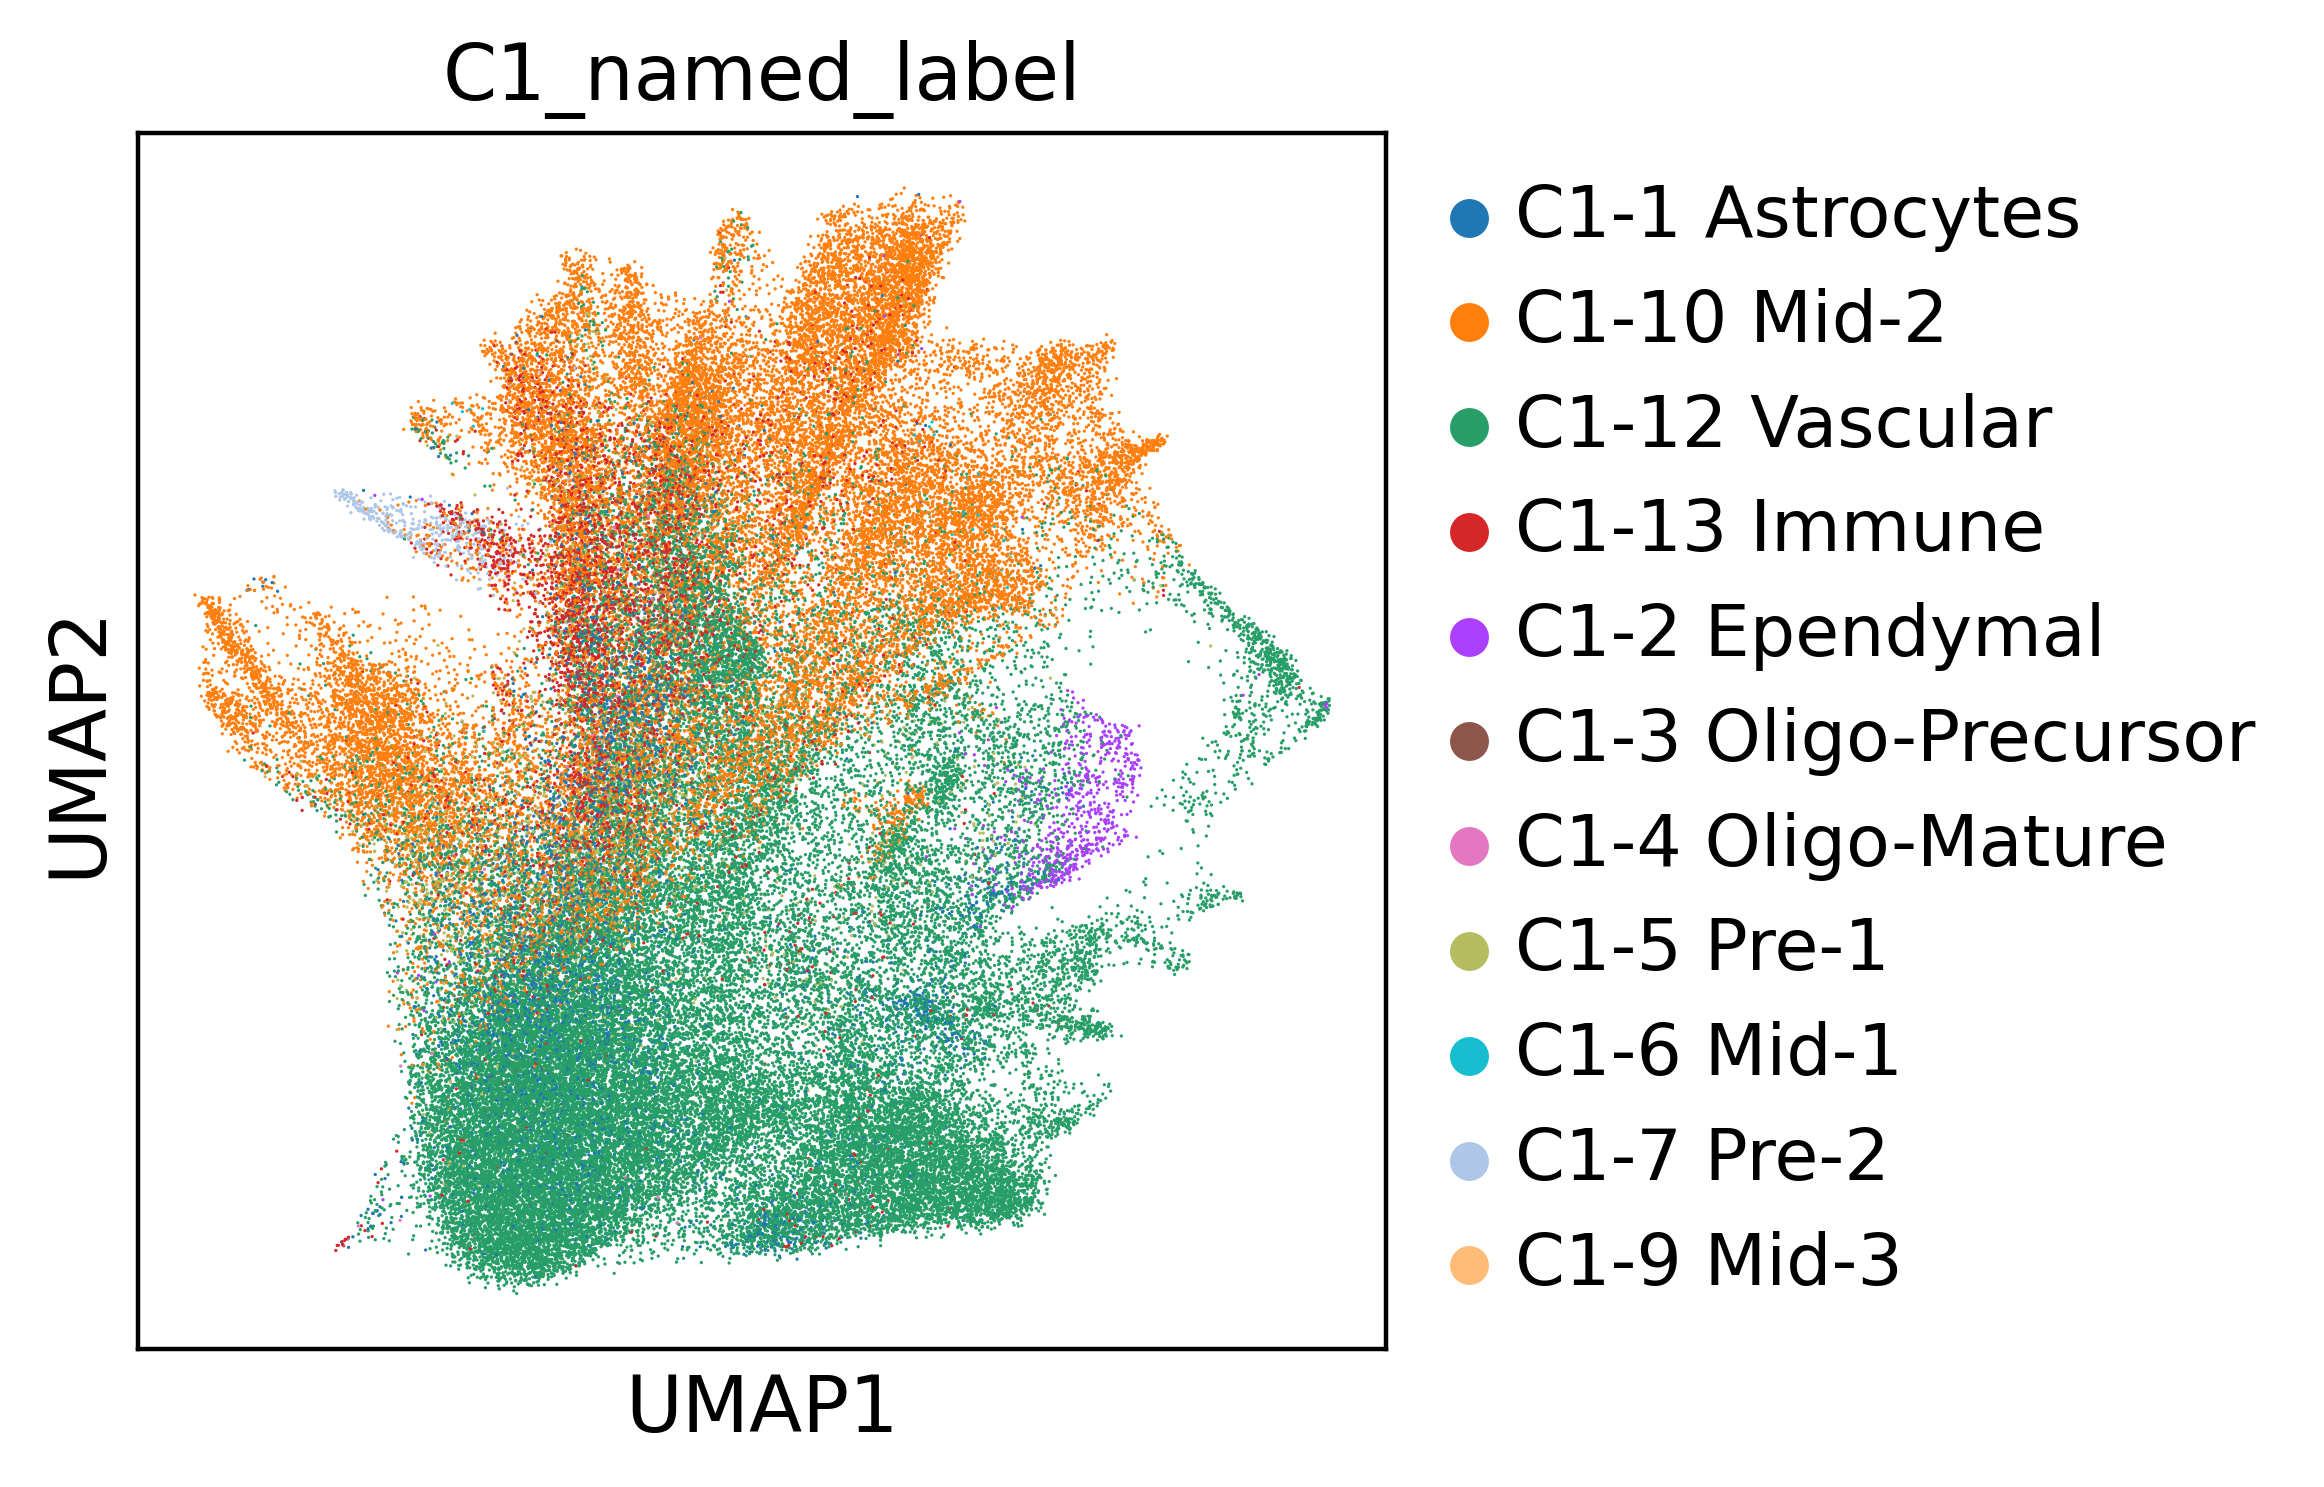

In [135]:
sc.pl.umap(query_adata, color = 'C1_named_label')

## Adding data into existing reference UMAP

Current python implementation of this relies on rapids and is not included here for now

In [ ]:
# To be added ....